In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
import pathlib

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


In [2]:
filepath = '/kaggle/input/spaceship-titanic/train.csv'
df = pd.read_csv('/kaggle/input/spaceship-titanic/train.csv')
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [3]:
df.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


# Which Datatypes are Categorical and Numerical ?

In [4]:
categorical_var = df.select_dtypes(include=['object']).columns
print(categorical_var)


Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'VIP',
       'Name'],
      dtype='object')


In [5]:
numerical_var = df.select_dtypes(include=['float64']).columns
print(numerical_var)

Index(['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'], dtype='object')


Checking the null values present in each column 

In [6]:
def nulls(df):
    nll = {}
    for col in df.columns:
        nll[col] = df[col].isnull().sum()
    df_nulls = pd.DataFrame(data=list(nll.values()),
                           index=list(nll.keys()),
                            columns=['nulls'])
    return(df_nulls)
nulls(df)

,nulls
PassengerId,0
HomePlanet,201
CryoSleep,217
Cabin,199
Destination,182
Age,179
VIP,203
RoomService,181
FoodCourt,183
ShoppingMall,208


Handling the none values :

* Categorical data - replace none with most common used word
* Numerical data - replace null with mean of the data

In [7]:
#Categorical
for cat_col in categorical_var:
    if cat_col != "Name":
        df[cat_col] = df[cat_col].fillna(df[cat_col].mode()[0])

/tmp/ipykernel_18/2104671028.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[cat_col] = df[cat_col].fillna(df[cat_col].mode()[0])


In [8]:
#Numerical
for num_col in numerical_var:
    df[num_col] = df[num_col].fillna(df[num_col].mean())

In [9]:
nulls(df)

,nulls
PassengerId,0
HomePlanet,0
CryoSleep,0
Cabin,0
Destination,0
Age,0
VIP,0
RoomService,0
FoodCourt,0
ShoppingMall,0


In [10]:
df.describe(include=['O'])

,PassengerId,HomePlanet,Cabin,Destination,Name
count,8693,8693,8693,8693,8493
unique,8693,3,6560,3,8473
top,0001_01,Earth,G/734/S,TRAPPIST-1e,Gollux Reedall
freq,1,4803,207,6097,2


Manually encoding all categorical features using dict method

In [11]:
#Homeplanet
unique_planets = df['HomePlanet'].unique()
# unique_planets
df['HomePlanet'] = df['HomePlanet'].map(dict(zip(unique_planets,list(range(len(unique_planets))))))
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,0,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,1,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,0,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,0,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,1,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [12]:
#Destination
unique_dest = df['Destination'].unique()
# unique_dest
df['Destination'] = df['Destination'].map(dict(zip(unique_dest,list(range(len(unique_dest))))))
df.head()


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,0,False,B/0/P,0,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,1,False,F/0/S,0,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,0,False,A/0/S,0,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,0,False,A/0/S,0,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,1,False,F/1/S,0,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [13]:
#CryoSleep
unique_sleep = df['CryoSleep'].unique()
# unique_sleep
df['CryoSleep'] = df['CryoSleep'].map(dict(zip(unique_sleep,list(range(len(unique_sleep))))))
df.head()


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,0,0,B/0/P,0,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,1,0,F/0/S,0,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,0,0,A/0/S,0,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,0,0,A/0/S,0,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,1,0,F/1/S,0,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [14]:
#VIP
unique_VIP = df['VIP'].unique()
# unique_dest
df['VIP'] = df['VIP'].map(dict(zip(unique_VIP,list(range(len(unique_VIP))))))
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,0,0,B/0/P,0,39.0,0,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,1,0,F/0/S,0,24.0,0,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,0,0,A/0/S,0,58.0,1,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,0,0,A/0/S,0,33.0,0,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,1,0,F/1/S,0,16.0,0,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


Removing unwanted or unecessary columns from the df (drop)

In [15]:
df.drop(['Name'], axis=1, inplace=True)

In [16]:
if 'train' in filepath:
    df.drop(['PassengerId'],axis=1, inplace=True)

In [17]:
df.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,0,0,B/0/P,0,39.0,0,0.0,0.0,0.0,0.0,0.0,False
1,1,0,F/0/S,0,24.0,0,109.0,9.0,25.0,549.0,44.0,True
2,0,0,A/0/S,0,58.0,1,43.0,3576.0,0.0,6715.0,49.0,False
3,0,0,A/0/S,0,33.0,0,0.0,1283.0,371.0,3329.0,193.0,False
4,1,0,F/1/S,0,16.0,0,303.0,70.0,151.0,565.0,2.0,True


Building two features for Cabin column (deck,port)

In [18]:
df['deck'] = df['Cabin'].apply(lambda s: s[0] if pd.notnull(s) else 'M')
df['port'] = df['Cabin'].apply(lambda s: s[-1] if pd.notnull(s) else 'M')

unique_deck = df['deck'].unique()
unique_port = df['port'].unique()

df['deck'] = df['deck'].map(dict(zip(unique_deck,list(range(len(unique_deck))))))
df['port'] = df['port'].map(dict(zip(unique_port,list(range(len(unique_port))))))

df.drop(['Cabin'], axis=1, inplace=True)

df.head()


,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,deck,port
0,0,0,0,39.0,0,0.0,0.0,0.0,0.0,0.0,False,0,0
1,1,0,0,24.0,0,109.0,9.0,25.0,549.0,44.0,True,1,1
2,0,0,0,58.0,1,43.0,3576.0,0.0,6715.0,49.0,False,2,1
3,0,0,0,33.0,0,0.0,1283.0,371.0,3329.0,193.0,False,2,1
4,1,0,0,16.0,0,303.0,70.0,151.0,565.0,2.0,True,1,1


In [19]:
df.to_csv('train_cleaned.csv')

In [20]:
pf = pd.read_csv('train_cleaned.csv')
pf.head()

,Unnamed: 0,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,deck,port
0,0,0,0,0,39.0,0,0.0,0.0,0.0,0.0,0.0,False,0,0
1,1,1,0,0,24.0,0,109.0,9.0,25.0,549.0,44.0,True,1,1
2,2,0,0,0,58.0,1,43.0,3576.0,0.0,6715.0,49.0,False,2,1
3,3,0,0,0,33.0,0,0.0,1283.0,371.0,3329.0,193.0,False,2,1
4,4,1,0,0,16.0,0,303.0,70.0,151.0,565.0,2.0,True,1,1


# Modelling and Training Dataset

In [21]:
df_train = pf
X = df_train.drop(["Transported"],axis = 1).values
y = df_train["Transported"].values

In [22]:
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42,test_size=0.2)
X_train.shape,y_train.shape, X_test.shape, y_test.shape

((6954, 13), (6954,), (1739, 13), (1739,))

Fitting some classification models

In [23]:
#Logistic regression
lg = LogisticRegression()
lg.fit(X_train,y_train)
lg_pred_score = lg.score(X_test,y_test)
lg_pred_score

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.7602070155261644

In [24]:
#Random Forest Classifier
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
rf_pred_score = rf.score(X_test,y_test)
rf_pred_score

0.7883841288096607

In [25]:
#Gradient Boosting Classifier
gb = GradientBoostingClassifier()
gb.fit(X_train,y_train)
gb_pred_score = gb.score(X_test,y_test)
gb_pred_score

0.7941345600920069

In [26]:
#Support Vector Machine 
from sklearn.svm import SVC
svc = SVC()
svc.fit(X_train,y_train)
svc_pred_score = svc.score(X_test,y_test)
svc_pred_score

0.7751581368602645

In [27]:
kf = pd.DataFrame(dict(model=['LogisticRegression',
                             'RandomForest','GradientBoosting',
                             'SupportVectorMachine'],
                      accuracy = [lg_pred_score,
                                 rf_pred_score,gb_pred_score,
                                 svc_pred_score]))
kf

,model,accuracy
0,LogisticRegression,0.760207
1,RandomForest,0.788384
2,GradientBoosting,0.794135
3,SupportVectorMachine,0.775158


(0.5, 1.0)

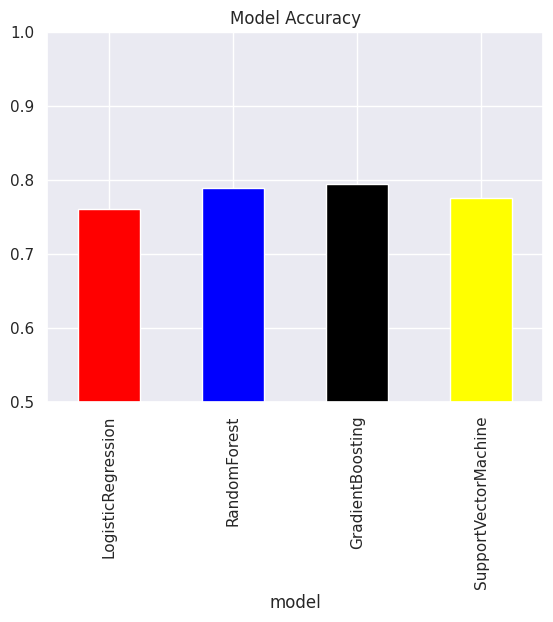

In [28]:
kf.plot(kind = 'bar',x='model',y='accuracy',title='Model Accuracy',legend=False,
       color = ['red','blue','black','yellow'])
plt.ylim(0.5,1)

In [29]:
filepath2 = '/kaggle/input/spaceship-titanic/test.csv'
mf = pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')
mf.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


In [30]:
categorical_var = mf.select_dtypes(include=['object']).columns
numerical_var = mf.select_dtypes(include=['float64']).columns
#Categorical
for cat_col in categorical_var:
    if cat_col != "Name":
        mf[cat_col] = mf[cat_col].fillna(mf[cat_col].mode()[0])
#Numerical
for num_col in numerical_var:
    mf[num_col] = mf[num_col].fillna(mf[num_col].mean())
#Homeplanet
unique_planets = mf['HomePlanet'].unique()
# unique_planets
mf['HomePlanet'] = mf['HomePlanet'].map(dict(zip(unique_planets,list(range(len(unique_planets))))))
#Destination
unique_dest = mf['Destination'].unique()
# unique_dest
mf['Destination'] = mf['Destination'].map(dict(zip(unique_dest,list(range(len(unique_dest))))))
#CryoSleep
unique_sleep = mf['CryoSleep'].unique()
# unique_sleep
mf['CryoSleep'] = mf['CryoSleep'].map(dict(zip(unique_sleep,list(range(len(unique_sleep))))))
#VIP
unique_VIP = mf['VIP'].unique()
# unique_dest
mf['VIP'] = mf['VIP'].map(dict(zip(unique_VIP,list(range(len(unique_VIP))))))

/tmp/ipykernel_18/2448554201.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  mf[cat_col] = mf[cat_col].fillna(mf[cat_col].mode()[0])


In [31]:
mf.drop(['Name'], axis=1, inplace=True)
mf['deck'] = mf['Cabin'].apply(lambda s: s[0] if pd.notnull(s) else 'M')
mf['port'] = mf['Cabin'].apply(lambda s: s[-1] if pd.notnull(s) else 'M')

unique_deck = mf['deck'].unique()
unique_port = mf['port'].unique()

mf['deck'] = mf['deck'].map(dict(zip(unique_deck,list(range(len(unique_deck))))))
mf['port'] = mf['port'].map(dict(zip(unique_port,list(range(len(unique_port))))))

mf.drop(['Cabin'], axis=1, inplace=True)

mf.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,deck,port
0,0013_01,0,0,0,27.0,0,0.0,0.0,0.0,0.0,0.0,0,0
1,0018_01,0,1,0,19.0,0,0.0,9.0,0.0,2823.0,0.0,1,0
2,0019_01,1,0,1,31.0,0,0.0,0.0,0.0,0.0,0.0,2,0
3,0021_01,1,1,0,38.0,0,0.0,6652.0,0.0,181.0,585.0,2,0
4,0023_01,0,1,0,20.0,0,10.0,0.0,635.0,0.0,0.0,1,0


In [32]:
mf.to_csv('test_cleaned.csv')

# Predictions using the most efficent and accurate model 

In [33]:
nf_test = pd.read_csv('test_cleaned.csv')
nf_test.head()


,Unnamed: 0,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,deck,port
0,0,0013_01,0,0,0,27.0,0,0.0,0.0,0.0,0.0,0.0,0,0
1,1,0018_01,0,1,0,19.0,0,0.0,9.0,0.0,2823.0,0.0,1,0
2,2,0019_01,1,0,1,31.0,0,0.0,0.0,0.0,0.0,0.0,2,0
3,3,0021_01,1,1,0,38.0,0,0.0,6652.0,0.0,181.0,585.0,2,0
4,4,0023_01,0,1,0,20.0,0,10.0,0.0,635.0,0.0,0.0,1,0


In [34]:
X_train = df_train.drop(['Transported'],axis=1)
y_train = df_train['Transported']
X_test = nf_test.drop(['PassengerId'],axis=1).copy()

In [35]:
model = SVC()
model.fit(X_train,y_train)
predictions = model.predict(X_test)

In [36]:
df_submissions = pd.DataFrame({'PassengerId':mf['PassengerId'],'Transported':predictions})
df_submissions
df_submissions.to_csv('submission.csv',index=False)